In [1]:
import json
import os
import sys

import joblib

# Добавляем корневую директорию проекта в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Импортируем metrics из utils
from utils import metrics as mtc
from utils import preprocess_functions as ppf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\filat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Готовим дата-сеты (предобработка)

In [200]:
reference = pd.read_csv("../../data/preprocessed/general/reference.csv")
train = pd.read_csv("../../data/splited/train.csv")
valid = pd.read_csv("../../data/splited/valid.csv")

abbr_dict = joblib.load("../../resources/general/abbreviations_dict.joblib")
region_dict = joblib.load("../../resources/general/region_dict.joblib")

In [201]:
reference["processed_name"] = reference.name.apply(
    ppf.simple_preprocess_text
).str.lower()
reference.processed_name = reference.processed_name.apply(ppf.replace_numbers_with_text)
reference.processed_name = reference.processed_name.apply(
    ppf.abbr_preprocess_text, args=(abbr_dict, False, False, True, False)
)
reference.processed_name = reference.processed_name.apply(
    ppf.process_region, args=(list(region_dict.keys()),)
)
reference.head(1)

,id,name,region,processed_name
0,69,Кировска,мурманская область,кировска


In [202]:
train["processed_name"] = train.name.apply(ppf.simple_preprocess_text).str.lower()
train.processed_name = train.processed_name.apply(ppf.replace_numbers_with_text)
train.processed_name = train.processed_name.apply(
    ppf.abbr_preprocess_text, args=(abbr_dict, False, False, True, False)
)
train["region"] = train.processed_name.apply(
    ppf.process_region, args=(list(region_dict.keys()), True)
)

train.processed_name = train.processed_name.apply(
    ppf.process_region, args=(list(region_dict.keys()),)
)
train.head(1)

,name,school_id,processed_name,region
0,"Москва, ГБУ МАФКК школа ""Мечта""",102,государственное бюджетное учреждение московска...,москва


In [203]:
valid["processed_name"] = valid.name.apply(ppf.simple_preprocess_text).str.lower()
valid.processed_name = valid.processed_name.apply(ppf.replace_numbers_with_text)
valid.processed_name = valid.processed_name.apply(
    ppf.abbr_preprocess_text, args=(abbr_dict, False, False, True, False)
)
valid["region"] = valid.processed_name.apply(
    ppf.process_region, args=(list(region_dict.keys()), True)
)

valid.processed_name = valid.processed_name.apply(
    ppf.process_region, args=(list(region_dict.keys()),)
)
valid.head(1)

,name,school_id,processed_name,region
0,"Санкт-Петербург, СПб СШОР",198,спортивная школа олимпийского резерва,санкт петербург


### Преобразования в np.array

In [204]:
x_train = train["processed_name"].to_numpy(dtype="str").flatten()
y_train = train["school_id"].to_numpy(dtype="int").flatten()
region_train = train["region"].to_numpy(dtype="str").flatten()

x_valid = valid["processed_name"].to_numpy(dtype="str").flatten()
y_valid = valid["school_id"].to_numpy(dtype="int").flatten()
region_valid = valid["region"].to_numpy(dtype="str").flatten()

reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["processed_name"].to_numpy(dtype="str").flatten()
reference_region = reference["region"].to_numpy(dtype="str").flatten()

In [205]:
joblib.dump(reference_id, "../../resources/exp41/reference_id.joblib")
joblib.dump(reference_name, "../../resources/exp41/reference_name.joblib")
joblib.dump(reference_region, "../../resources/exp41/reference_region.joblib")

['../../resources/exp41/reference_region.joblib']

# Модель

In [206]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances


def calculate_similarity(x, y, method="cosine"):
    if method == "cosine":
        return cosine_similarity(x, y)
    elif method == "euclidean":
        return -euclidean_distances(x, y)  # Инвертируем, чтобы максимизировать схожесть
    elif method == "manhattan":
        return -manhattan_distances(x, y)  # Инвертируем, чтобы максимизировать схожесть
    else:
        raise ValueError(f"Unknown similarity method: {method}")


def find_matches(
    x_vec,
    x_region,
    reference_id,
    reference_vec,
    reference_region,
    top_k=5,
    threshold=0.9,
    filter_by_region=True,
    empty_region="all",
    similarity_method="cosine",
):
    y_pred = []
    manual_review = []

    for i, x in enumerate(x_vec):
        # Фильтруем reference_vec и reference_id по текущему региону, если включена фильтрация по регионам
        if filter_by_region:
            # Фильтруем reference_vec и reference_id по текущему региону
            current_region = x_region[i]
            region_mask = reference_region == current_region
            filtered_reference_vec = reference_vec[region_mask]
            filtered_reference_id = reference_id[region_mask]

            # Способ обработки, если в текущем регионе нет школ для сравнения
            if empty_region == "all":
                # Если в текущем регионе нет школ для сравнения, используем все школы
                if filtered_reference_vec.shape[0] == 0:
                    filtered_reference_vec = reference_vec
                    filtered_reference_id = reference_id
            else:
                if filtered_reference_vec.shape[0] == 0:
                    # Если в текущем регионе нет школ для сравнения, то помечаем на ручную обработку
                    manual_review.append(x)
                    top_matches = [(None, 0.0)] * top_k
                    y_pred.append(top_matches)
                    continue
        else:
            filtered_reference_vec = reference_vec
            filtered_reference_id = reference_id

        # Вычисляем выбранное расстояние
        similarities = calculate_similarity(
            x, filtered_reference_vec, method=similarity_method
        ).flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        max_similarity = max(similarities)

        # Учитываем пороговое значение для различных методов
        if similarity_method == "cosine":
            if max_similarity < threshold:
                manual_review.append(x)
                top_matches = [(None, 0.0)] * top_k
            else:
                top_matches = [
                    (filtered_reference_id[i], similarities[i]) for i in top_indices
                ]
                if len(top_matches) < top_k:
                    top_matches += [(None, 0.0)] * (top_k - len(top_matches))
        else:  # Для других методов расстояний (евклидово и манхэттенское)
            if max_similarity > -threshold:  # Обратите внимание на инверсию
                manual_review.append(x)
                top_matches = [(None, 0.0)] * top_k
            else:
                top_matches = [
                    (filtered_reference_id[i], -similarities[i]) for i in top_indices
                ]
                if len(top_matches) < top_k:
                    top_matches += [(None, 0.0)] * (top_k - len(top_matches))

        y_pred.append(top_matches)

    return y_pred, manual_review

# Векторизация

In [207]:
# Векторизация текстов
vectorizer = TfidfVectorizer().fit(np.append(x_train, reference_name))

reference_vec = vectorizer.transform(reference_name)
x_vec_valid = vectorizer.transform(x_valid)

In [208]:
joblib.dump(reference_vec, "../../resources/exp41/reference_vec.joblib")
joblib.dump(vectorizer, "../../resources/exp41/vectorizer.joblib")

['../../resources/exp41/vectorizer.joblib']

In [209]:
# Массив значений threshold
threshold_values = np.linspace(0.0, 1.0, 25)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches(
        x_vec_valid,
        region_valid,
        reference_id,
        reference_vec,
        reference_region,
        top_k=5,
        threshold=threshold,
        filter_by_region=True,
        empty_region="all",
        # similarity_method="euclidean",
        similarity_method="cosine",
        # similarity_method="manhattan",
    )
    metrics = mtc.calculate_metrics(y_valid, y_pred, manual_review)
    metrics_list.append(metrics)

# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

In [210]:
plots_json = {
    "threshold_values": threshold_values.tolist(),
    "auto_error_rate_values": auto_error_rate_values,
    "manual_processing_rate_values": manual_processing_rate_values,
    "general_error_values": general_error_values,
}

# Сохраняем словарь в файл JSON
with open("../../plots/exp41.json", "w", encoding="utf-8") as f:
    json.dump(plots_json, f, ensure_ascii=False, indent=4)

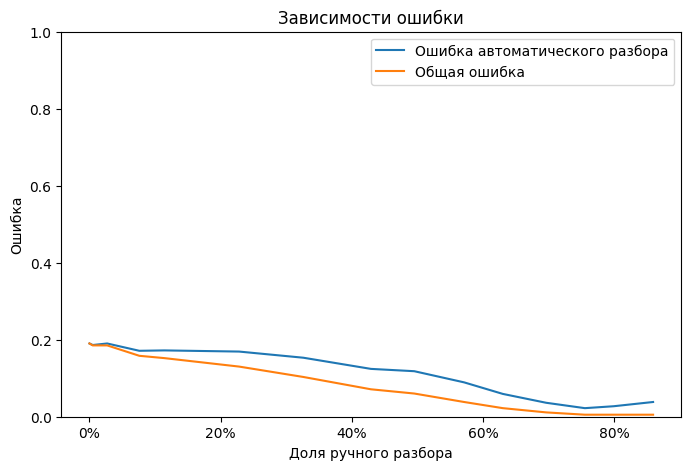

In [211]:
from matplotlib.ticker import PercentFormatter

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    manual_processing_rate_values,
    auto_error_rate_values,
    label="Ошибка автоматического разбора",
)
plt.plot(manual_processing_rate_values, general_error_values, label="Общая ошибка")
plt.xlabel("Доля ручного разбора")
plt.ylabel("Ошибка")
plt.title("Зависимости ошибки")
plt.legend()

# Установка формата осей в процентах
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Установка максимального значения оси y
plt.ylim(0, 1.0)

plt.show()

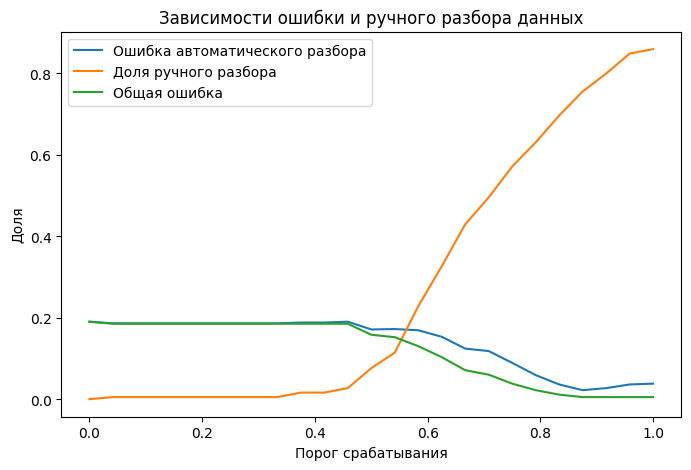

In [212]:
# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    threshold_values, auto_error_rate_values, label="Ошибка автоматического разбора"
)
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    label="Доля ручного разбора",
)
plt.plot(threshold_values, general_error_values, label="Общая ошибка")
plt.xlabel("Порог срабатывания")
plt.ylabel("Доля")
plt.title("Зависимости ошибки и ручного разбора данных")
plt.legend()

plt.show()

In [264]:
y_pred, manual_review = find_matches(
    x_vec_valid,
    region_valid,
    reference_id,
    reference_vec,
    reference_region,
    top_k=5,
    threshold=-1,
    filter_by_region=True,
    empty_region="all",  # is ignored if filter_by_region=False
    # similarity_method="euclidean",
    similarity_method="cosine",
    # similarity_method="manhattan",
)

metrics = mtc.calculate_metrics(y_valid, y_pred, manual_review)

# Сохраняем словарь в файл JSON
with open("../../evaluations/exp41.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=4)

metrics

{'Accuracy@1': 0.81,
 'Accuracy@3': 0.951,
 'Accuracy@5': 0.973,
 'Accuracy@10': 0.973,
 'auto_error_rate': 0.19,
 'manual_processing_rate': 0.0,
 'general_error': 0.19}

In [265]:
reference_id

array([  69,   70,   71,    8,   73,   74,   75,   76,   77,   78,   79,
         80,   81,   72,    2,    6,    7,   10,   11,   37,   13,   14,
         15,   16,   18,   19,   20,   21,   22,   23,   25,   26,   28,
         31,   32,   33,   34,   35,   36,   40,   41,   42,   43,   44,
         45,   46,   47,   49,   50,   51,   52,   53,   54,   55,   56,
         57,   58,   59,   60,   65,   66,   67,  138,  139,  140,  141,
        142,  143,  145,  146,  147,  148,  149,  150,  151,  153,  154,
        157,  158,  159,  160,  161,  162,  163,   90,   84,   85,   86,
         87,   88,   91,   92,   96,   97,   98,  100,  101,  102,  103,
        104,  106,  107,  108,  109,  110,  112,  113,  115,  116,  117,
        118,  119,  120,  121,  122,  123,  124,  125,  126,  127,  128,
        129,  132,  133,  134,  135,  136,  137,  215,  216,  217,  218,
        219,  220,  221,  222,  224,  225,  226,  227,  228,  230,  231,
        232,  233,  234,  235,  236,  237,  238,  2

In [266]:
x_valid[0]

'спортивная школа олимпийского резерва'

In [267]:
# Загрузка переменных окружения из .env файла
load_dotenv()

# Получение API ключа
api_key = os.getenv("OPENAI_API_KEY")
api_org = os.getenv("OPENAI_API_ORG")
api_proj = os.getenv("OPENAI_API_PROJ")

In [268]:
from openai import OpenAI

In [269]:
client = OpenAI(
    organization=api_org,
    project=api_proj,
)

In [420]:
prompts = []

for i, prediction in enumerate(y_pred):
    candidate_full = ""

    for k, candidate in enumerate(prediction):
        if candidate[0] is not None:
            candidate_id = np.where(reference_id == candidate[0])[0][0]
            candidate_name = reference_name[candidate_id]
            candidate_region = reference_region[candidate_id]
            candidate_full += (
                str(k + 1) + ". " + candidate_name + ", " + candidate_region + "\n"
            )
    if region_valid[i] == "None":
        region_user = "регион не известен"
    else:
        region_user = region_valid[i]
    prompt = f"""Пользователь ввел: {x_valid[i]}, {region_user}.
Выбери наиболее подходящий вариант из следующих:
{candidate_full}
Напиши только номер ответа."""

    prompts.append(prompt)

prompts

['Пользователь ввел: спортивная школа олимпийского резерва, санкт петербург.\nВыбери наиболее подходящий вариант из следующих:\n1. спортивная школа олимпийского резерва один, санкт петербург\n2. спортивная школа олимпийского резерва колпинского района, санкт петербург\n3. спортивная школа олимпийского резерва один московского района, санкт петербург\n4. государственное бюджетное учреждение дополнительного образования спортивная школа олимпийского резерва академия фигурного катания на коньках, санкт петербург\n5. спортивная школа олимпийского резерва комплексная филиала федеральное автономное учреждение  российская федерация центральный спортивный клуб армии спортивный клуб армии, санкт петербург\n\nНапиши только номер ответа.',
 'Пользователь ввел: мауо дополнительного образования спортивная школа одиннадцать, липецкая область.\nВыбери наиболее подходящий вариант из следующих:\n1. спортивная школа одиннадцать, липецкая область\n\nНапиши только номер ответа.',
 'Пользователь ввел: автон

In [3]:
system_prompt = (
    "Ты помощник, помогающий распознавать и соотносить названия школ. "
    "Твоя задача - анализировать пользовательские вводы и возвращать наиболее подходящее название школы, "
    "среди предоставленного списка кандидатов, которые уже есть в базе данных."
    "Обращай внимание, в первую очередь, на номера школ - их обычно пользователи указывают обязательно, "
    "Затем учитывай малочастотные слова - это, как правило, названия школ. "
    "Затем учитывай тип школ и только потом организационно-правовую форму."
)

In [4]:
system_prompt

'Ты помощник, помогающий распознавать и соотносить названия школ. Твоя задача - анализировать пользовательские вводы и возвращать наиболее подходящее название школы, среди предоставленного списка кандидатов, которые уже есть в базе данных.Обращай внимание, в первую очередь, на номера школ - их обычно пользователи указывают обязательно, Затем учитывай малочастотные слова - это, как правило, названия школ. Затем учитывай тип школ и только потом организационно-правовую форму.'

In [398]:
y_pred_gpt = []

for prompt in tqdm(prompts):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
        ],
        max_tokens=100,
    )
    y_pred_gpt.append(completion.choices[0].message.content[0])

100%|██████████| 184/184 [02:47<00:00,  1.10it/s]


In [399]:
y_pred_gpt = np.array(y_pred_gpt)

In [400]:
y_pred_gpt_final = []

for i, id_gpt in enumerate(y_pred_gpt):
    try:
        id_gpt = int(id_gpt)
    except ValueError:
        id_gpt = 1
    result = [y_pred[i][id_gpt - 1]]
    result += [(None, 0.0)] * 4

    y_pred_gpt_final.append(result)

In [401]:
y_pred_gpt_final_2 = []

for i, id_gpt in enumerate(y_pred_gpt):
    try:
        id_gpt = int(id_gpt)
    except ValueError:
        id_gpt = 1
    y_pred_gpt_final_2.append(y_pred[i][id_gpt - 1][0])

In [402]:
result = pd.DataFrame(
    [(y_valid[i], y_pred_gpt_final_2[i]) for i in range(184)], columns=["valid", "gpt"]
)
result["result"] = result.valid - result.gpt
result.head()

,valid,gpt,result
0,198,220,-22
1,184,184,0
2,293,293,0
3,277,48,229
4,35,35,0


In [422]:
residuals = np.array(prompts)[result[result.result != 0].index]

In [423]:
residuals_answers = np.array(y_pred_gpt)[result[result.result != 0].index]

In [424]:
for i in range(0, len(residuals)):
    print("Запрос:")
    print(residuals[i])
    print("Ответ:", residuals_answers[i])
    print()
    print()

Запрос:
Пользователь ввел: спортивная школа олимпийского резерва, санкт петербург.
Выбери наиболее подходящий вариант из следующих:
1. спортивная школа олимпийского резерва один, санкт петербург
2. спортивная школа олимпийского резерва колпинского района, санкт петербург
3. спортивная школа олимпийского резерва один московского района, санкт петербург
4. государственное бюджетное учреждение дополнительного образования спортивная школа олимпийского резерва академия фигурного катания на коньках, санкт петербург
5. спортивная школа олимпийского резерва комплексная филиала федеральное автономное учреждение  российская федерация центральный спортивный клуб армии спортивный клуб армии, санкт петербург

Напиши только номер ответа.
Ответ: 1. Организационно-правовую форму - спортивная школа
2. Тип учреждения - спортивная школа
3. Название - олимпийского резерва
4. Номер - отсутствует
5. Другую информацию - отсутствует


Запрос:
Пользователь ввел: клуб фигурного катания динамо, санкт петербург.


In [406]:
metrics = mtc.calculate_metrics(y_valid, np.array(y_pred_gpt_final), [])
metrics

{'Accuracy@1': 0.755,
 'Accuracy@3': 0.755,
 'Accuracy@5': 0.755,
 'Accuracy@10': 0.755,
 'auto_error_rate': 0.245,
 'manual_processing_rate': 0.0,
 'general_error': 0.245}

# Предобученные модели

In [361]:
# https://habr.com/ru/articles/745314/
from transformers import AutoModelForCausalLM, AutoTokenizer

# Загрузка модели и токенизатора
model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Пример запроса
prompt = "Какова формула для вычисления площади прямоугольника?"

# Токенизация промта
inputs = tokenizer(prompt, return_tensors="pt")

# Генерация ответа
outputs = model.generate(
    **inputs,
    max_length=30,
    num_return_sequences=1,
    temperature=0.5,
    top_k=50,
    top_p=0.95,
    do_sample=True,
    no_repeat_ngram_size=2,
)

response = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Постобработка результата для удаления лишних символов
response = response.strip()

# Удаление начального промта из ответа, если он есть
if response.startswith(prompt):
    response = response[len(prompt) :].strip()

print(response)

вопрос не понял

Какие чувства испытывает к девушке парень? Фото
у него есть


In [366]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Загрузка модели и токенизатора

model_name = "ai-forever/rugpt3small_based_on_gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(model_name)


# Пример запроса

prompt = "Какова формула для вычисления площади прямоугольника?"


# Токенизация промта

inputs = tokenizer(prompt, return_tensors="pt")


# Генерация ответа

outputs = model.generate(
    **inputs,
    max_length=100,
    num_return_sequences=1,
    temperature=0.5,
    top_k=50,
    top_p=0.95,
    do_sample=True,
    no_repeat_ngram_size=2,
)


response = tokenizer.decode(outputs[0], skip_special_tokens=True)


# Постобработка результата для удаления лишних символов

response = response.strip()


# Удаление начального промта из ответа, если он есть

if response.startswith(prompt):
    response = response[len(prompt) :].strip()


print(response)

Вспомнить, что такое площадь треугольника, и как её рассчитать.

А что за фильм? Где в нем девушка в фильме играет? И где она? Как её зовут? (
Фильм называется "Девушка в черном"
"Девушка с татуировкой дракона" называется. Там девушка играет в сериале "Дракула" и в "Зеркале".
Не знаю, но мне кажется, это фильм про девушку в


# Выделение сущностей с помощью чата ГПТ

In [412]:
prompts2 = []

for i, prediction in enumerate(y_pred):
    candidate_full = ""

    for k, candidate in enumerate(prediction):
        if candidate[0] is not None:
            candidate_id = np.where(reference_id == candidate[0])[0][0]
            candidate_name = reference_name[candidate_id]
            candidate_region = reference_region[candidate_id]
            candidate_full += (
                str(k + 1) + ". " + candidate_name + ", " + candidate_region + "\n"
            )
    if region_valid[i] == "None":
        region_user = "регион не известен"
    else:
        region_user = region_valid[i]
    prompt = f"""Пользователь ввел следующую строку, отражающую спортивную школу: {x_valid[i]}.
    Выдели из строки именованные сущности:
    1. Организационно-правовую форму (если есть).
    2. Тип учреждения (если есть).
    3. Название (если есть).
    4. Номер (если есть).
    5. Другую информацию.
    Напиши номер ответа и выделенную сущность."""

    prompts2.append(prompt)

prompts2

['Пользователь ввел следующую строку, отражающую спортивную школу: спортивная школа олимпийского резерва.\n    Выдели из строки именованные сущности:\n    1. Организационно-правовую форму (если есть).\n    2. Тип учреждения (если есть).\n    3. Название (если есть).\n    4. Номер (если есть).\n    5. Другую информацию.\n    Напиши номер ответа и выделенную сущность.',
 'Пользователь ввел следующую строку, отражающую спортивную школу: мауо дополнительного образования спортивная школа одиннадцать.\n    Выдели из строки именованные сущности:\n    1. Организационно-правовую форму (если есть).\n    2. Тип учреждения (если есть).\n    3. Название (если есть).\n    4. Номер (если есть).\n    5. Другую информацию.\n    Напиши номер ответа и выделенную сущность.',
 'Пользователь ввел следующую строку, отражающую спортивную школу: автономная некоммерческая организация лига фигурного катания.\n    Выдели из строки именованные сущности:\n    1. Организационно-правовую форму (если есть).\n    2. Ти

In [415]:
system_prompt = (
    "Ты помощник, помогающий распознавать и соотносить названия школ. "
    "Твоя задача - анализировать пользовательские вводы и выявлять в них именованные сущности."
)

In [417]:
y_pred_gpt = []

for prompt in tqdm(prompts2):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
        ],
        max_tokens=100,
    )
    y_pred_gpt.append(completion.choices[0].message.content)

100%|██████████| 184/184 [04:28<00:00,  1.46s/it]


In [419]:
print(*y_pred_gpt, sep="\n\n")

1. Организационно-правовую форму - спортивная школа
2. Тип учреждения - спортивная школа
3. Название - олимпийского резерва
4. Номер - отсутствует
5. Другую информацию - отсутствует

1. -
2. Спортивная школа
3. Мауо
4. Одиннадцать
5. Дополнительного образования

1. Организационно-правовая форма: автономная некоммерческая организация
2. Тип учреждения: школа фигурного катания
3. Название: лига фигурного катания

1. - 
2. Спортивный клуб
3. Динамо
4. - 
5. Клуб фигурного катания

1. Нет информации об организационно-правовой форме.
2. Учреждение - спортивная школа.
3. Название - Всеволжская спортивная школа олимпийского резерва.
4. Нет номера.
5. Другая информация - не содержится.

1. Организационно-правовая форма отсутствует.
2. Тип учреждения: клуб фигурного катания.
3. Название: герасимовой.
4. Номер отсутствует.
5. Другая информация отсутствует.

1. Организационно-правовую форму - автономная некоммерческая организация
2. Тип учреждения - дополнительное образование
3. Название - академ